# Calibration of the flooding model

## Model

The simulator predicts the water height $H$ depending on the flowrate $Q$.

We consider the following four variable:

* $Q$ : the river flowrate ($m^3/s$)
* $Ks$ : the Strickler coefficient ($m^{1/3}/s$)
* $Z_v$ : the downstream riverbed level (m)
* $Z_m$ : the upstream riverbed level (m)

When the Strickler coefficient increases, the riverbed generates less friction to the water flow.

## Parameters

We consider the following parameters:

* the length of the river $L$ = 5000 (m),
* the width of the river $B$ = 300 (m).

## Outputs

We make the hypothesis that the slope of the river is nonpositive and close to zero, which implies: 
$$
\alpha = \frac{Z_m - Z_v}{L},
$$

if $Z_m \geq Z_v$. 
The height of the river is:
$$
H = \left(\frac{Q}{K_s B \sqrt{\alpha}}\right)^{0.6},
$$

for any $K_s, Q>0$.

<img src="river_section_adjusted_light.png" width="400" />

## Distribution

We assume that the river flowrate has the following truncated Gumbel distribution:

|Variable|Distribution|
| ------------- |-------------|
|Q|Gumbel(scale=558, mode=1013)>0|

## Parameters to calibrate

The vector of parameters to calibrate is: 
$$
\theta = (K_s,Z_v,Z_m).
$$

The variables to calibrate are $(K_s,Z_v,Z_m)$ and are set to the following values:
$$
K_s = 30, \qquad Z_v = 50, \qquad Z_m = 55.
$$

## Observations

In this section, we describe the statistical model associated with the $n$ observations.
The errors of the water heights are associated with a gaussian distribution with a zero mean and a standard variation equal to:
$$
\sigma=0.1.
$$

Therefore, the observed water heights are:
$$
H_i = G(Q_i,K_s,Z_v,Z_m) + \epsilon_i
$$

for $i=1,...,n$ where
$$
\epsilon \sim \mathcal{N}(0,\sigma^2)
$$

and we make the hypothesis that the observation errors are independent.
We consider a sample size equal to:
$$
n=100.
$$

The observations are the couples $\{(Q_i,H_i)\}_{i=1,...,n}$, i.e. each observation is a couple made of the flowrate and the corresponding river height.

## Analysis

In this model, the variables $Z_m$ and $Z_v$ are not identifiables, since only the difference $Z_m-Z_v$ matters. Hence, calibrating this model requires some regularization.

## Generate the observations

In [1]:
import numpy as np
import openturns as ot
ot.ResourceMap.SetAsUnsignedInteger('Normal-SmallDimension', 1)

We define the model $g$ which has 4 inputs and one output H.

The nonlinear least squares does not take into account for bounds in the parameters. Therefore, we ensure that the output is computed whatever the inputs. The model fails into two situations:

* if $K_s<0$,
* if $Z_v-Z_m<0$.

In these cases, we return an infinite number, so that the optimization algorithm does not get trapped.

In [2]:
def functionFlooding(X) :
    L = 5.0e3
    B = 300.0
    Q, K_s, Z_v, Z_m = X
    alpha = (Z_m - Z_v)/L
    if alpha < 0.0 or K_s <= 0.0:
        H = np.inf
    else:
        H = (Q/(K_s*B*np.sqrt(alpha)))**(3.0/5.0)
    return [H]

In [3]:
g = ot.PythonFunction(4, 1, functionFlooding) 
g = ot.MemoizeFunction(g)
g.setOutputDescription(["H (m)"])

Create the input distribution for $Q$.

In [4]:
Q = ot.Gumbel(558.0, 1013.0)
Q = ot.TruncatedDistribution(Q,ot.TruncatedDistribution.LOWER)
Q.setDescription(["Q (m3/s)"])
Q

class=TruncatedDistribution name=TruncatedDistribution distribution=class=Gumbel name=Gumbel dimension=1 beta=558 gamma=1013 bounds=class=Interval name=Unnamed dimension=1 lower bound=class=Point name=Unnamed dimension=1 values=[0] upper bound=class=Point name=Unnamed dimension=1 values=[19000.8] finite lower bound=[1] finite upper bound=[0] thresholdRealization=0.5

Set the parameters to be calibrated.

In [5]:
K_s = ot.Dirac(30.0)
Z_v = ot.Dirac(50.0)
Z_m = ot.Dirac(55.0)
K_s.setDescription(["Ks (m^(1/3)/s)"])
Z_v.setDescription(["Zv (m)"])
Z_m.setDescription(["Zm (m)"])

Create the joint input distribution.

In [6]:
inputRandomVector = ot.ComposedDistribution([Q, K_s, Z_v, Z_m])

Create a Monte-Carlo sample of the output H.

In [7]:
nbobs = 100
inputSample = inputRandomVector.getSample(nbobs)
outputH = g(inputSample)

Observe the distribution of the output H.

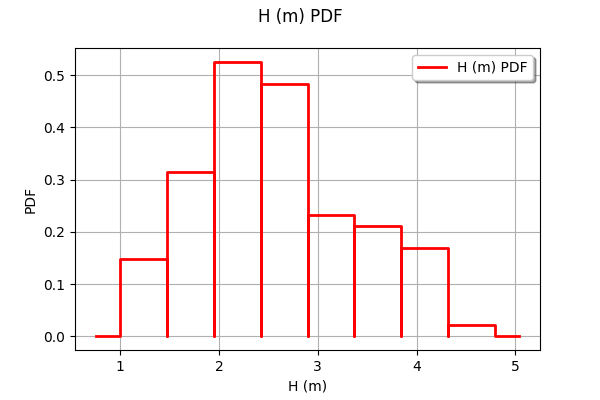

In [8]:
ot.HistogramFactory().build(outputH).drawPDF()

Generate the observation noise and add it to the output of the model.

In [9]:
sigmaObservationNoiseH = 0.1 # (m)
noiseH = ot.Normal(0.,sigmaObservationNoiseH)
sampleNoiseH = noiseH.getSample(nbobs)
Hobs = outputH + sampleNoiseH

Plot the Y observations versus the X observations.

In [10]:
Qobs = inputSample[:,0]

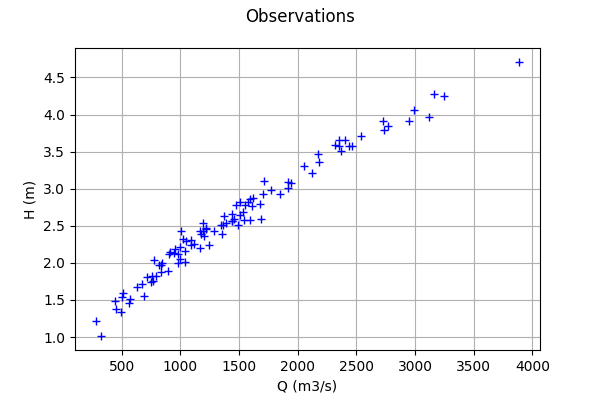

In [11]:
graph = ot.Graph("Observations","Q (m3/s)","H (m)",True)
cloud = ot.Cloud(Qobs,Hobs)
graph.add(cloud)
graph

## Setting the calibration parameters

Define the value of the reference values of the $\theta$ parameter. In the bayesian framework, this is called the mean of the *prior* gaussian distribution. In the data assimilation framework, this is called the *background*.

In [12]:
KsInitial = 20.
ZvInitial = 49.
ZmInitial = 51.
thetaPrior = ot.Point([KsInitial,ZvInitial,ZmInitial])

The following statement create the calibrated function from the model. The calibrated parameters Ks, Zv, Zm are at indices 1, 2, 3 in the inputs arguments of the model.

In [13]:
calibratedIndices = [1,2,3]
mycf = ot.ParametricFunction(g, calibratedIndices, thetaPrior)

## Calibration with linear least squares

The `LinearLeastSquaresCalibration` class performs the linear least squares calibration by linearizing the model in the neighbourhood of the reference point.

In [14]:
algo = ot.LinearLeastSquaresCalibration(mycf, Qobs, Hobs, thetaPrior, "SVD")

The `run` method computes the solution of the problem.

In [15]:
algo.run()

In [16]:
calibrationResult = algo.getResult()

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [17]:
thetaStar = calibrationResult.getParameterMAP()
thetaStar

class=Point name=Unnamed dimension=3 values=[-1.01509e+08,2.32325e+23,2.32325e+23]

In this case, we see that there seems to be a great distance from the reference value of $\theta$ to the optimum: the values seem too large in magnitude. The value of the optimum $K_s$ is nonpositive. In fact, there is an identification problem because the Jacobian matrix is rank-degenerate.

## Diagnostic of the identification issue

In this section, we show how to diagnose the identification problem.

The `getParameterPosterior` method returns the posterior gaussian distribution of $\theta$.

In [18]:
distributionPosterior = calibrationResult.getParameterPosterior()
distributionPosterior

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[-1.01509e+08,2.32325e+23,2.32325e+23] sigma=class=Point name=Unnamed dimension=3 values=[1.44409e+26,1.13527e+32,1.13527e+32] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,3.61879e-25,-3.61879e-25,3.61879e-25,1,1,-3.61879e-25,1,1]

We see that there is a large covariance matrix diagonal. 

Let us compute a 95% confidence interval for the solution $\theta^\star$.

In [19]:
distributionPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[-3.22835e+26,-2.53797e+32,-2.53797e+32] upper bound=class=Point name=Unnamed dimension=3 values=[3.22835e+26,2.53797e+32,2.53797e+32] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

The confidence interval is *very* large.

In [20]:
mycf.setParameter(thetaPrior)
thetaDim = thetaPrior.getDimension()
jacobianMatrix = ot.Matrix(nbobs,thetaDim)
for i in range(nbobs):
    jacobianMatrix[i,:] = mycf.parameterGradient(Qobs[i]).transpose()
jacobianMatrix[0:5,:]

class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=5 columns=3 values=[-0.133438,-0.170638,-0.0808351,-0.0546252,-0.105857,0.667192,0.853188,0.404175,0.273126,0.529285,-0.667192,-0.853188,-0.404175,-0.273126,-0.529285]

In [21]:
jacobianMatrix.computeSingularValues()

class=Point name=Unnamed dimension=3 values=[9.72877,1.6948e-10,2.59677e-25]

We can see that there are two singular values which are relatively close to zero. 

This explains why the Jacobian matrix is close to being rank-degenerate.

## Conclusion of the linear least squares calibration

There are several methods to solve the problem.

* Given that the problem is not identifiable, we can use some regularization method. Two methods are provided in the library: the gaussian linear least squares `GaussianLinearCalibration` and the gaussian non linear least squares `GaussianNonlinearCalibration`.
* We can change the problem, replacing it with a problem which is identifiable. In the flooding model, replacing $Z_v-Z_m$ with $\Delta Z$ allows to solve the issue.

## Calibration with non linear least squares

The `NonLinearLeastSquaresCalibration` class performs the non linear least squares calibration by minimizing the squared euclidian norm between the predictions and the observations.

In [22]:
algo = ot.NonLinearLeastSquaresCalibration(mycf, Qobs, Hobs, thetaPrior)

The `run` method computes the solution of the problem.

In [23]:
algo.run()

In [24]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [25]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=3 values=[27.7666,47.0271,52.9729]

We can compute a 95% confidence interval of the parameter $\theta^\star$. 

This confidence interval is based on bootstrap, based on a sample size equal to 100 (as long as the value of the `ResourceMap` key "NonLinearLeastSquaresCalibration-BootstrapSize" is unchanged). This confidence interval reflects the sensitivity of the optimum to the variability in the observations.

In [26]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[27.5899,46.963,52.8972] upper bound=class=Point name=Unnamed dimension=3 values=[27.9164,47.1028,53.037] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

In this case, the value of the parameter $K_s$ is quite accurately computed, but there is a relatively large uncertainty on the values of $Z_v$ and $Z_m$.

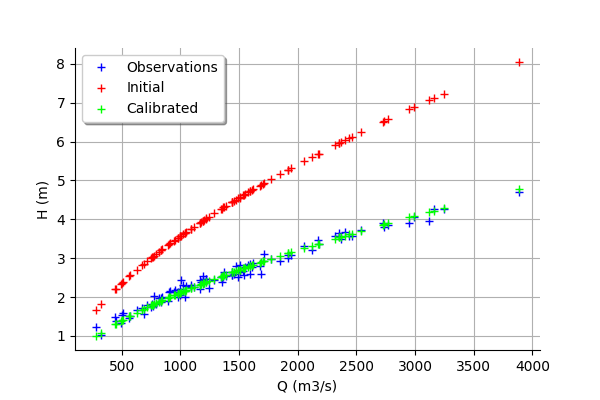

In [27]:
graph = calibrationResult.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

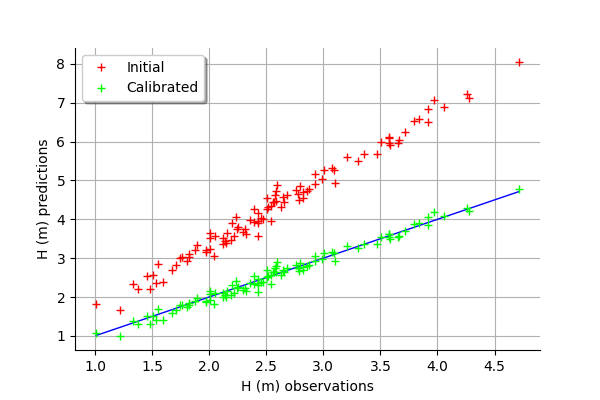

In [28]:
calibrationResult.drawObservationsVsPredictions()

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

In [29]:
observationError = calibrationResult.getObservationsError()
observationError

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[-0.00982925] sigma=class=Point name=Unnamed dimension=1 values=[0.107724] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

We can see that the observation error is close to have a zero mean and a standard deviation equal to 0.1.

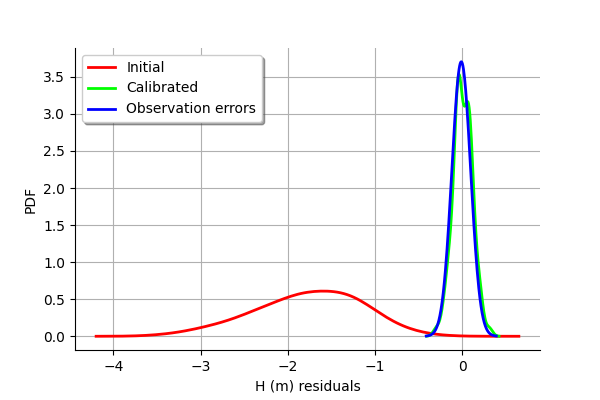

In [30]:
graph = calibrationResult.drawResiduals()
graph.setLegendPosition("topleft")
graph

The analysis of the residuals shows that the distribution is centered on zero and symmetric. This indicates that the calibration performed well. 

Moreover, the distribution of the residuals is close to being gaussian.

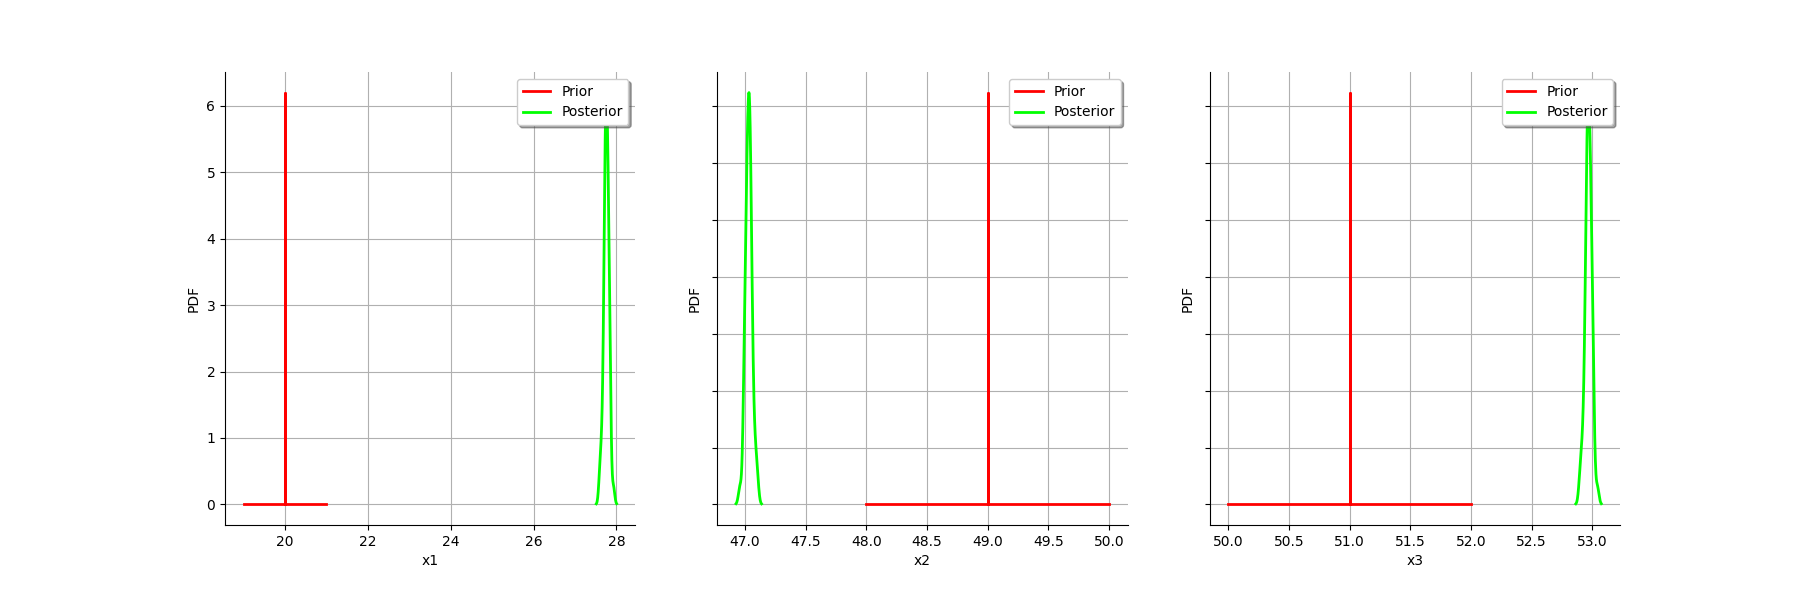

In [31]:
calibrationResult.drawParameterDistributions()

## Gaussian linear calibration

The standard deviation of the observations.

In [32]:
sigmaH = 0.5 # (m^2)

Define the covariance matrix of the output Y of the model.

In [33]:
errorCovariance = ot.CovarianceMatrix(1)
errorCovariance[0,0] = sigmaH**2

Define the covariance matrix of the parameters $\theta$ to calibrate.

In [34]:
sigmaKs = 5.
sigmaZv = 1.
sigmaZm = 1.

In [35]:
sigma = ot.CovarianceMatrix(3)
sigma[0,0] = sigmaKs**2
sigma[1,1] = sigmaZv**2
sigma[2,2] = sigmaZm**2
sigma

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[25,0,0,0,1,0,0,0,1]

The `GaussianLinearCalibration` class performs the gaussian linear calibration by linearizing the model in the neighbourhood of the prior.

In [36]:
algo = ot.GaussianLinearCalibration(mycf, Qobs, Hobs, thetaPrior, sigma, errorCovariance,"SVD")

The `run` method computes the solution of the problem.

In [37]:
algo.run()

In [38]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [39]:
thetaStar = calibrationResult.getParameterMAP()
thetaStar

class=Point name=Unnamed dimension=3 values=[24.5218,48.0956,51.9044]

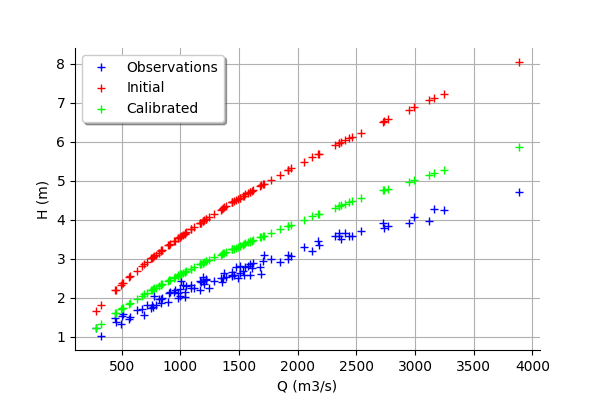

In [40]:
graph = calibrationResult.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

We see that the output of the model after calibration is closer to the observations. However, there is still a distance from the outputs of the model to the observations. This indicates that the calibration cannot be performed with this method.

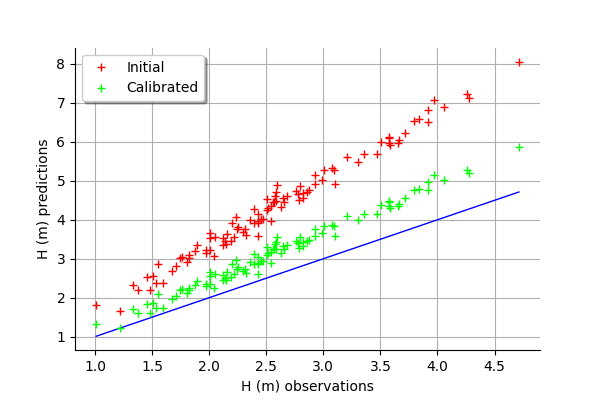

In [41]:
calibrationResult.drawObservationsVsPredictions()

In this case, the fit is better after calibration, but not perfect. Indeed, the cloud of points after calibration is not centered on the diagonal. 

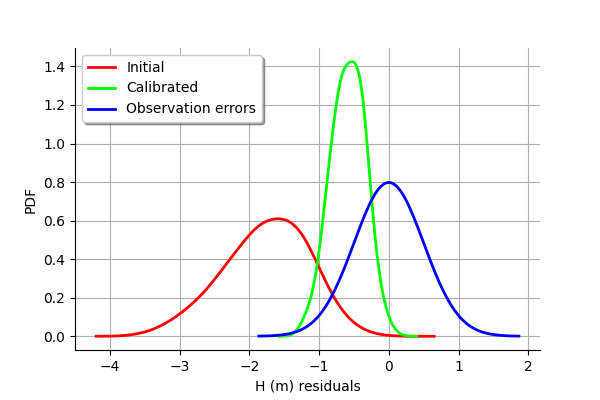

In [42]:
graph = calibrationResult.drawResiduals()
graph.setLegendPosition("topleft")
graph

We see that the distribution of the residual is not centered on zero: the mean residual is approximately -0.5, which implies that the predictions are, on average, smaller than the observations. This is a proof that the calibration cannot be performed with this method in this particular case.

The `getParameterPosterior` method returns the posterior gaussian distribution of $\theta$.

In [43]:
distributionPosterior = calibrationResult.getParameterPosterior()
distributionPosterior

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[24.5218,48.0956,51.9044] sigma=class=Point name=Unnamed dimension=3 values=[4.08431,0.816862,0.816862] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0.498657,-0.498657,0.498657,1,0.498657,-0.498657,0.498657,1]

We can compute a 95% confidence interval of the parameter $\theta^\star$.

In [44]:
distributionPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[14.944,46.1801,49.9888] upper bound=class=Point name=Unnamed dimension=3 values=[34.0996,50.0112,53.8199] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

We see that there is a large uncertainty on the value of the parameter $K_s$ which can be as small as 14 and as large as 34. 

We can compare the prior and posterior distributions of the marginals of $\theta$. 

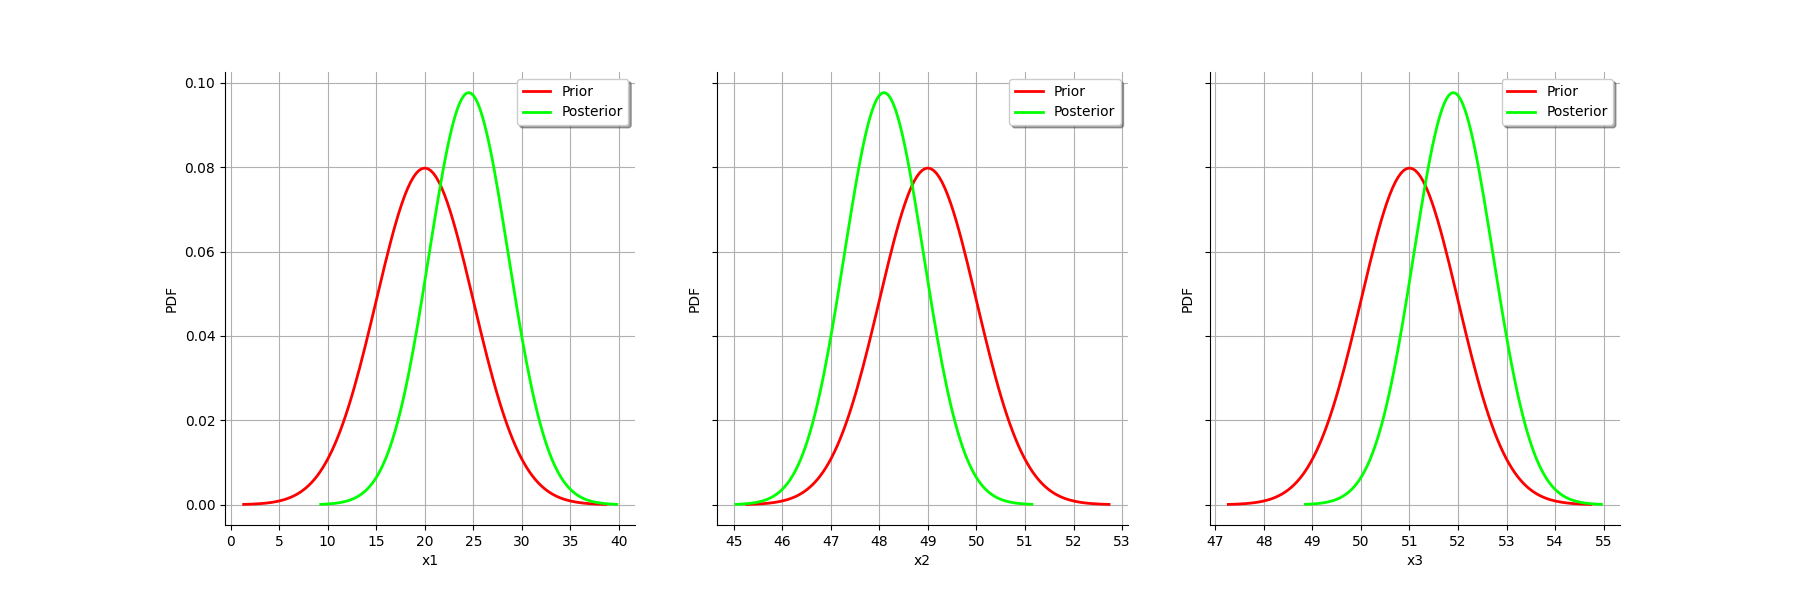

In [45]:
calibrationResult.drawParameterDistributions()

The two distributions are different, which shows that the calibration is sensible to the observations (if the observations were not sensible, the two distributions were superimposed). Moreover, the two distributions are quite close, which implies that the prior distribution has played a roled in the calibration (otherwise the two distributions would be completely different, indicating that only the observations were taken into account). 

## Gaussian nonlinear calibration

The `GaussianNonLinearCalibration` class performs the gaussian nonlinear calibration.

In [46]:
algo = ot.GaussianNonLinearCalibration(mycf, Qobs, Hobs, thetaPrior, sigma, errorCovariance)

The `run` method computes the solution of the problem.

In [47]:
algo.run()

In [48]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [49]:
thetaStar = calibrationResult.getParameterMAP()
thetaStar

class=Point name=Unnamed dimension=3 values=[30.6486,47.6198,52.3802]

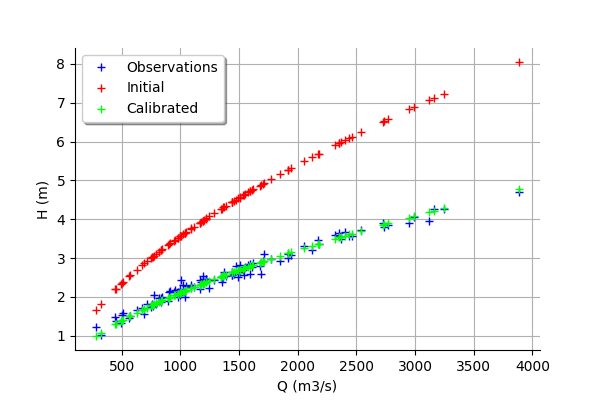

In [50]:
graph = calibrationResult.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

We see that the output of the model after calibration is in the middle of the observations: the calibration seems correct.

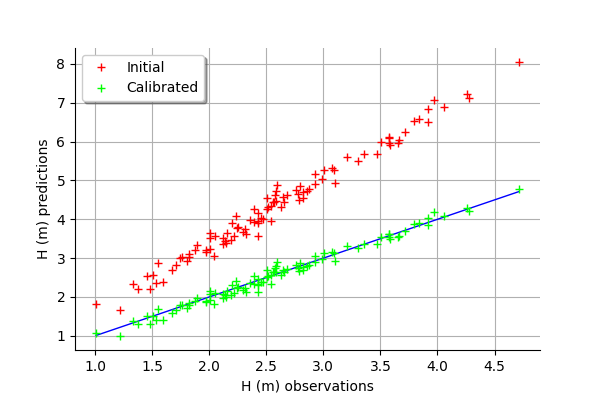

In [51]:
calibrationResult.drawObservationsVsPredictions()

The fit is excellent after calibration. Indeed, the cloud of points after calibration is on the diagonal. 

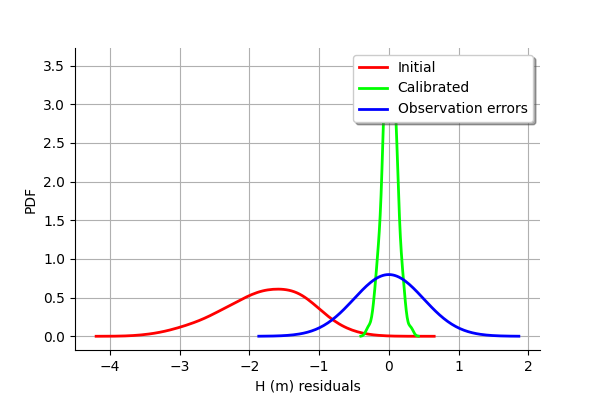

In [52]:
calibrationResult.drawResiduals()

We see that the histogram of the residual is centered on zero. This is a proof that the calibration did perform correctly.

The `getParameterPosterior` method returns the posterior gaussian distribution of $\theta$.

In [53]:
distributionPosterior = calibrationResult.getParameterPosterior()

We can compute a 95% confidence interval of the parameter $\theta^\star$.

In [54]:
distributionPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[30.5954,47.5559,52.3734] upper bound=class=Point name=Unnamed dimension=3 values=[31.1491,47.6266,52.4441] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

We see that there is a small uncertainty on the value of all parameters.

We can compare the prior and posterior distributions of the marginals of $\theta$. 

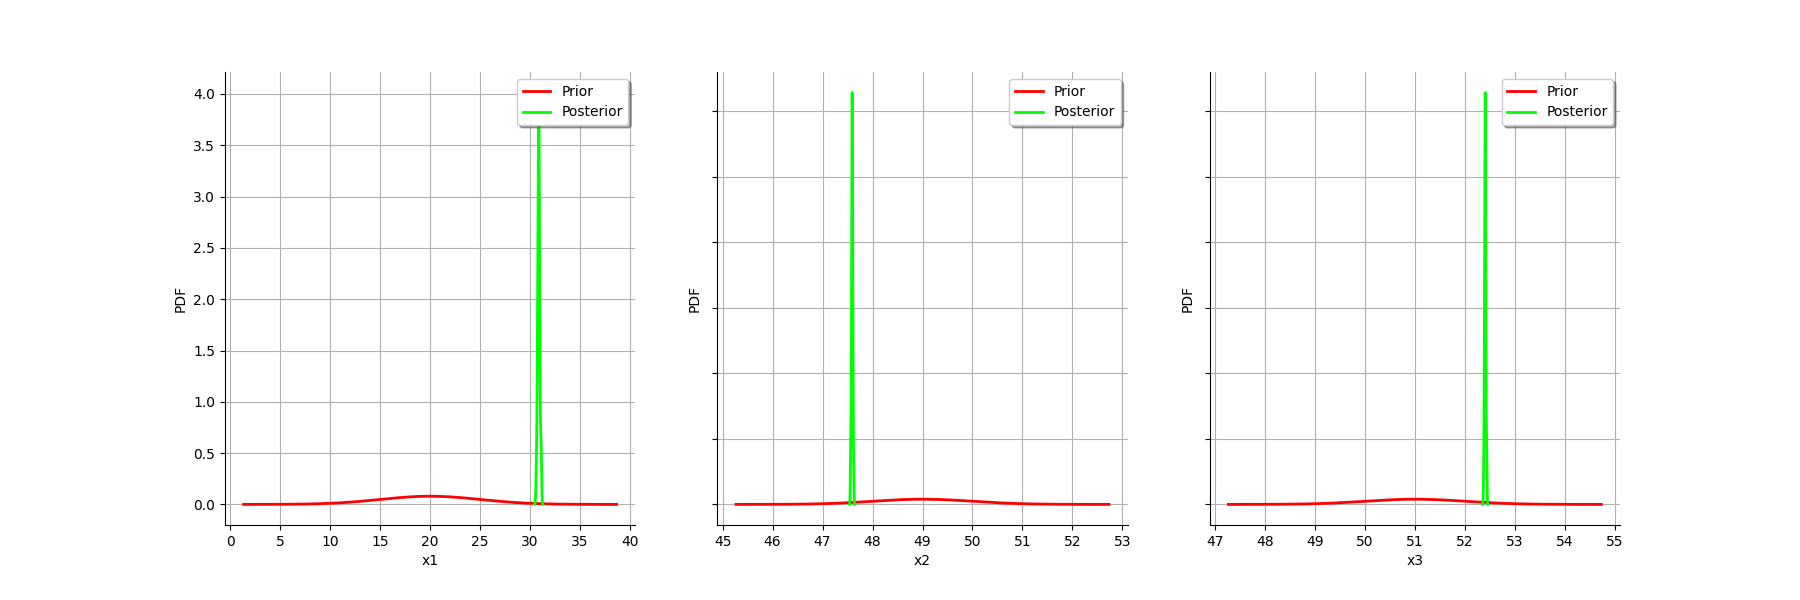

In [55]:
calibrationResult.drawParameterDistributions()

The two distributions are very different, with a spiky posterior distribution. This shows that the calibration is very sensible to the observations. 

## Tuning the posterior distribution estimation

The "GaussianNonLinearCalibration-BootstrapSize" key controls the posterior distribution estimation.

* If "GaussianNonLinearCalibration-BootstrapSize" > 0 (by default it is equal to 100), then a bootstrap resample algorithm is used to see the dispersion of the MAP estimator. This allows to see the variability of the estimator with respect to the finite observation sample.
* If "GaussianNonLinearCalibration-BootstrapSize" is zero, then the gaussian linear calibration estimator is used (i.e. the `GaussianLinearCalibration` class) at the optimum. This is called the Laplace approximation. 

We must configure the key before creating the object (otherwise changing the parameter does not change the result). 

In [56]:
ot.ResourceMap_SetAsUnsignedInteger("GaussianNonLinearCalibration-BootstrapSize",0) 

In [57]:
algo = ot.GaussianNonLinearCalibration(mycf, Qobs, Hobs, thetaPrior, sigma, errorCovariance)

In [58]:
algo.run()

In [59]:
calibrationResult = algo.getResult()

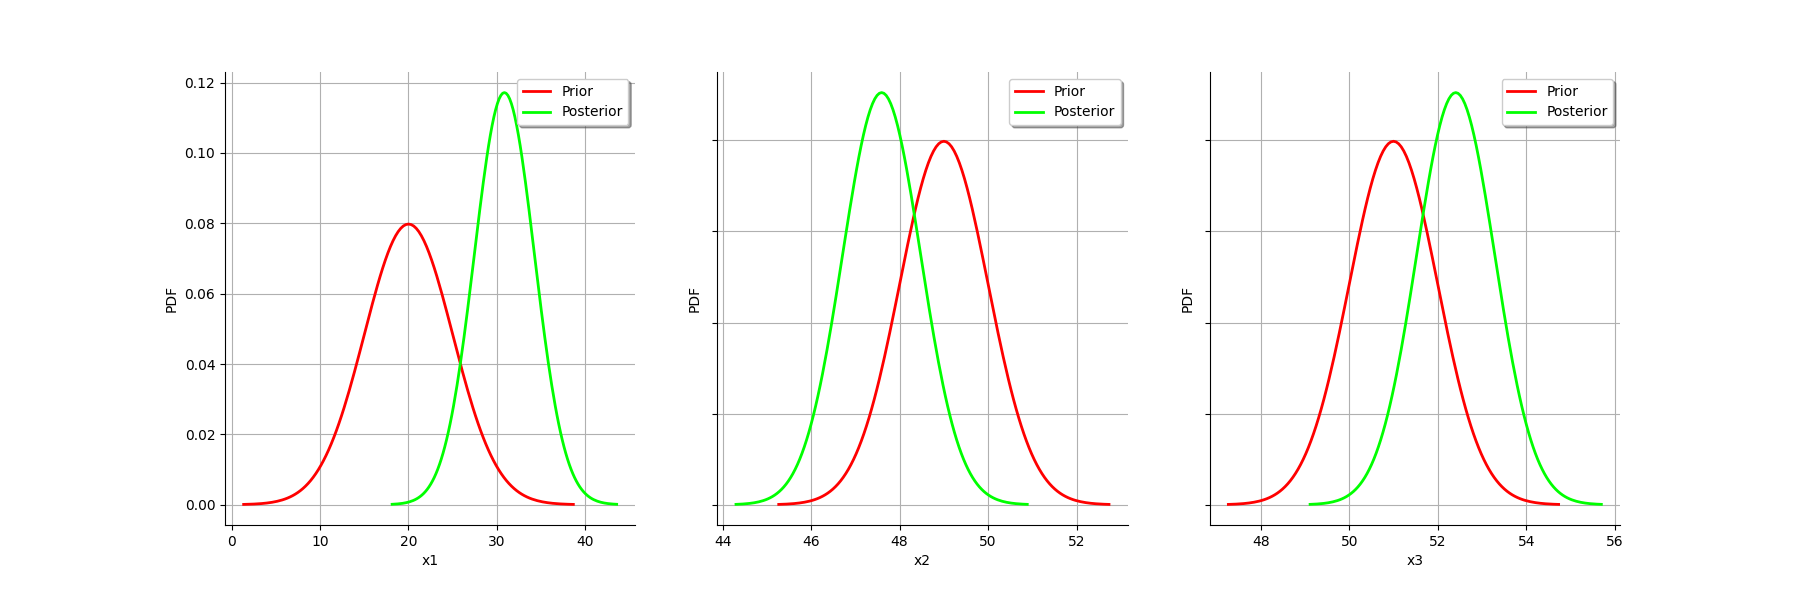

In [60]:
calibrationResult.drawParameterDistributions()

As we can see, this does not change much the posterior distribution, which remains spiky. 